In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
import os
import math

2024-05-07 07:16:20.400694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 07:16:20.400811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 07:16:20.528664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [6]:
BASE_DIR = Path('/kaggle/input/captchanumberdataset/captcha_number_dataset')

IMAGES = sorted(list(map(str, list(BASE_DIR.glob('*.png')))))
LABELS = [img.split(os.path.sep)[-1].split('.png')[0] for img in IMAGES]
CHARACTERS = set(char for LABEL in LABELS for char in LABEL)

print(f'Number of Images found: {len(IMAGES)}')
print(f'Number of Labels found: {len(LABELS)}')
print(f'Number of Unique Characters found: {len(CHARACTERS)}')
print(f'Character List: {CHARACTERS}')

Number of Images found: 100000
Number of Labels found: 100000
Number of Unique Characters found: 10
Character List: {'5', '6', '7', '2', '0', '8', '3', '4', '1', '9'}


In [7]:
IMAGES[0], LABELS[0]

('/kaggle/input/captchanumberdataset/captcha_number_dataset/00000.png',
 '00000')

In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

IMG_WIDTH, IMG_HEIGHT = 150, 40
downsample_factor = 4
max_length = max([len(label) for label in LABELS])
MAX_CHARS = len(CHARACTERS)
max_length

5

## Data Pre-Processing

In [9]:
char_to_num = layers.StringLookup(vocabulary=list(CHARACTERS),
                                  num_oov_indices=0,
                                  mask_token=None)

num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), 
                                  mask_token=None, 
                                  num_oov_indices=0,
                                  invert=True)

In [10]:
def split_data(images, labels, train_size=0.8, shuffle=True):
    size = len(images)
    
    indices = np.arange(size)
    
    if shuffle:
        np.random.shuffle(indices)
        
    train_samples = int(size * train_size)
    
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid

In [11]:
def encode_single_sample(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.one_hot(indices=label, depth=MAX_CHARS+1)
    # return {'image': img, 'label':label}
    return img, label

In [12]:
X_train, X_valid, y_train, y_valid = split_data(np.array(IMAGES), np.array(LABELS))

In [13]:
X_train[0], y_train[0], tf.strings.reduce_join(num_to_char(char_to_num(tf.strings.unicode_split(y_train[0], input_encoding="UTF-8")))).numpy().decode('utf-8')

('/kaggle/input/captchanumberdataset/captcha_number_dataset/98370.png',
 '98370',
 '98370')

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, 
                      num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

valid_dataset = (
    valid_dataset.map(encode_single_sample, 
                      num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

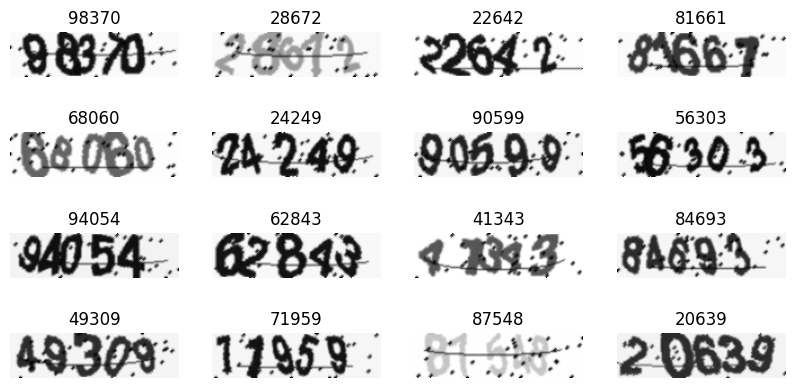

In [15]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
        
#    images = batch['image']
#    labels = batch['label']
    images = batch[0]
    labels = batch[1]
    # print(batch[1].shape)
    # print('Single Label Shape', labels[0].shape,' Label Value is: ', labels[0])
    for i in range(16):
        img = (images[i]*255).numpy().astype('uint8')
        ori_label = []
        
        for l in labels[i]:
            ori_label.append(np.argmax(l))
        
        label = tf.strings.reduce_join(num_to_char(ori_label)).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

## Model

In [16]:
class SqueezeLayer(layers.Layer):
    def __init__(self, name='squeeze_layer'):
        super().__init__(name=name)
        pass
        
    def call(self, inp):
        return tf.squeeze(inp, axis=2)

In [17]:
def get_model_2():
    
    tf.random.set_seed(108)
    
    img_inp = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name='image')
    
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', name='conv_1')(img_inp)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(x)
    
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name="conv_3_bn")(x)
    x = layers.ReLU(name="conv_3_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_3')(x)
    
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name="conv_4_bn")(x)
    x = layers.ReLU(name="conv_4_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_4')(x)
    
    x = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name="conv_5_bn")(x)
    x = layers.ReLU(name="conv_5_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_5')(x)

    x = layers.GlobalAveragePooling2D()(x)
  
    x = layers.Dense(max_length * (len(CHARACTERS) + 4), name='dense_3')(x)
    x = layers.BatchNormalization(name="dense_3_bn")(x)
    x = layers.ReLU(name="dense_3_relu")(x)
    x = layers.Dropout(0.5)(x)

    new_shape = (max_length , len(CHARACTERS) + 4)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    
    x = layers.Dense(64, name='dense_4')(x)    
    x = layers.BatchNormalization(name="dense_4_bn")(x)
    x = layers.ReLU(name="dense_4_relu")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(len(CHARACTERS) + 1, name='dense_prediction')(x)
    x = layers.BatchNormalization(name="prediction_bn")(x)
    out = layers.Activation('softmax', name='prediction')(x)
    
    model = tf.keras.Model(img_inp, out, name="OCR_Model")

    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['acc', tf.keras.metrics.AUC(name='auc'), ])
    model.summary()
    
    return model

In [18]:
model_2 = get_model_2()

Model: "OCR_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 150, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 150, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_bn (BatchNormalization)  │ (None, 150, 40, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (ReLU)              │ (None, 150, 40, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 75, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 75, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_bn (BatchNormalization)  │ (None, 75, 20, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_relu (ReLU)              │ (None, 75, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 37, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 37, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_bn (BatchNormalization)  │ (None, 37, 10, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_relu (ReLU)              │ (None, 37, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 18, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 18, 5, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_bn (BatchNormalization)  │ (None, 18, 5, 256)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_relu (ReLU)              │ (None, 18, 5, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 9, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 9, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5_bn (BatchNormalization)  │ (None, 9, 2, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5_relu (ReLU)              │ (None, 9, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_5 (MaxPooling2D)           │ (None, 4, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 70)             │        35,910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3_bn (BatchNormalization) │ (None, 70)             │           280 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,610,133 (6.14 MB)

 Trainable params: 1,607,859 (6.13 MB)

 Non-trainable params: 2,274 (8.88 KB)

In [21]:
EPOCHS = 100
PATIENCE = 10
initial_learning_rate = 0.01

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE, restore_best_weights=True)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))


lrate = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=0)


history = model_2.fit(train_dataset, 
                    validation_data=valid_dataset, 
                    epochs=EPOCHS, callbacks=[lrate, early_stopping])

Epoch 1/100
   4/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - acc: 0.0883 - auc: 0.5200 - loss: 2.7633    

I0000 00:00:1715067838.491047     156 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 137s 47ms/step - acc: 0.3974 - auc: 0.8182 - loss: 1.6441 - val_acc: 0.2784 - val_auc: 0.7527 - val_loss: 2.8647 - learning_rate: 0.0100
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - acc: 0.8005 - auc: 0.9760 - loss: 0.6540 - val_acc: 0.7498 - val_auc: 0.9673 - val_loss: 0.7741 - learning_rate: 0.0100
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - acc: 0.8354 - auc: 0.9819 - loss: 0.5534 - val_acc: 0.7272 - val_auc: 0.9491 - val_loss: 0.9541 - learning_rate: 0.0100
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - acc: 0.8552 - auc: 0.9861 - loss: 0.4803 - val_acc: 0.8359 - val_auc: 0.9872 - val_loss: 0.4875 - learning_rate: 0.0100
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - acc: 0.8639 - auc: 0.9880 - loss: 0.4420 - val_acc: 0.8624 - val_auc: 0.9882 - val_loss: 0.4499 - learning_rate: 0.0100
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - acc: 0.8718 - auc: 0.9890 - loss: 0.4176 - val_acc: 0.713

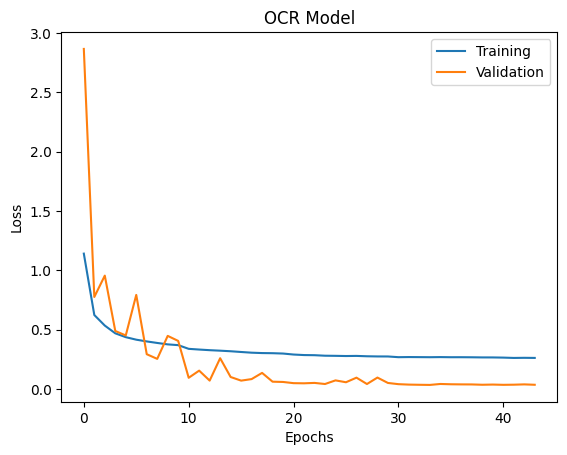

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('OCR Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

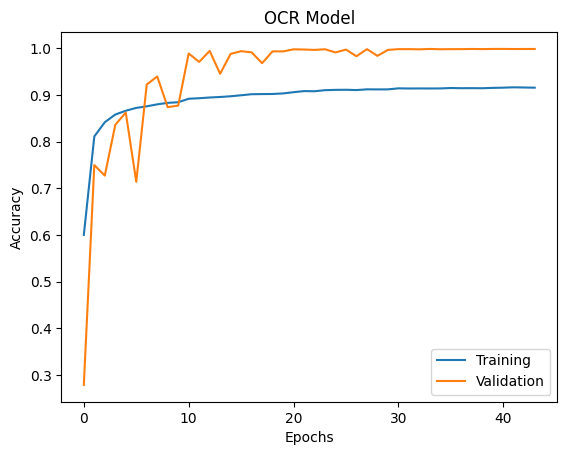

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('OCR Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [24]:
val_loss, val_acc, val_auc = model_2.evaluate(valid_dataset, verbose=0)
print(f'Validation Accuracy: {val_acc*100:.3f}%')

Validation Accuracy: 99.874%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


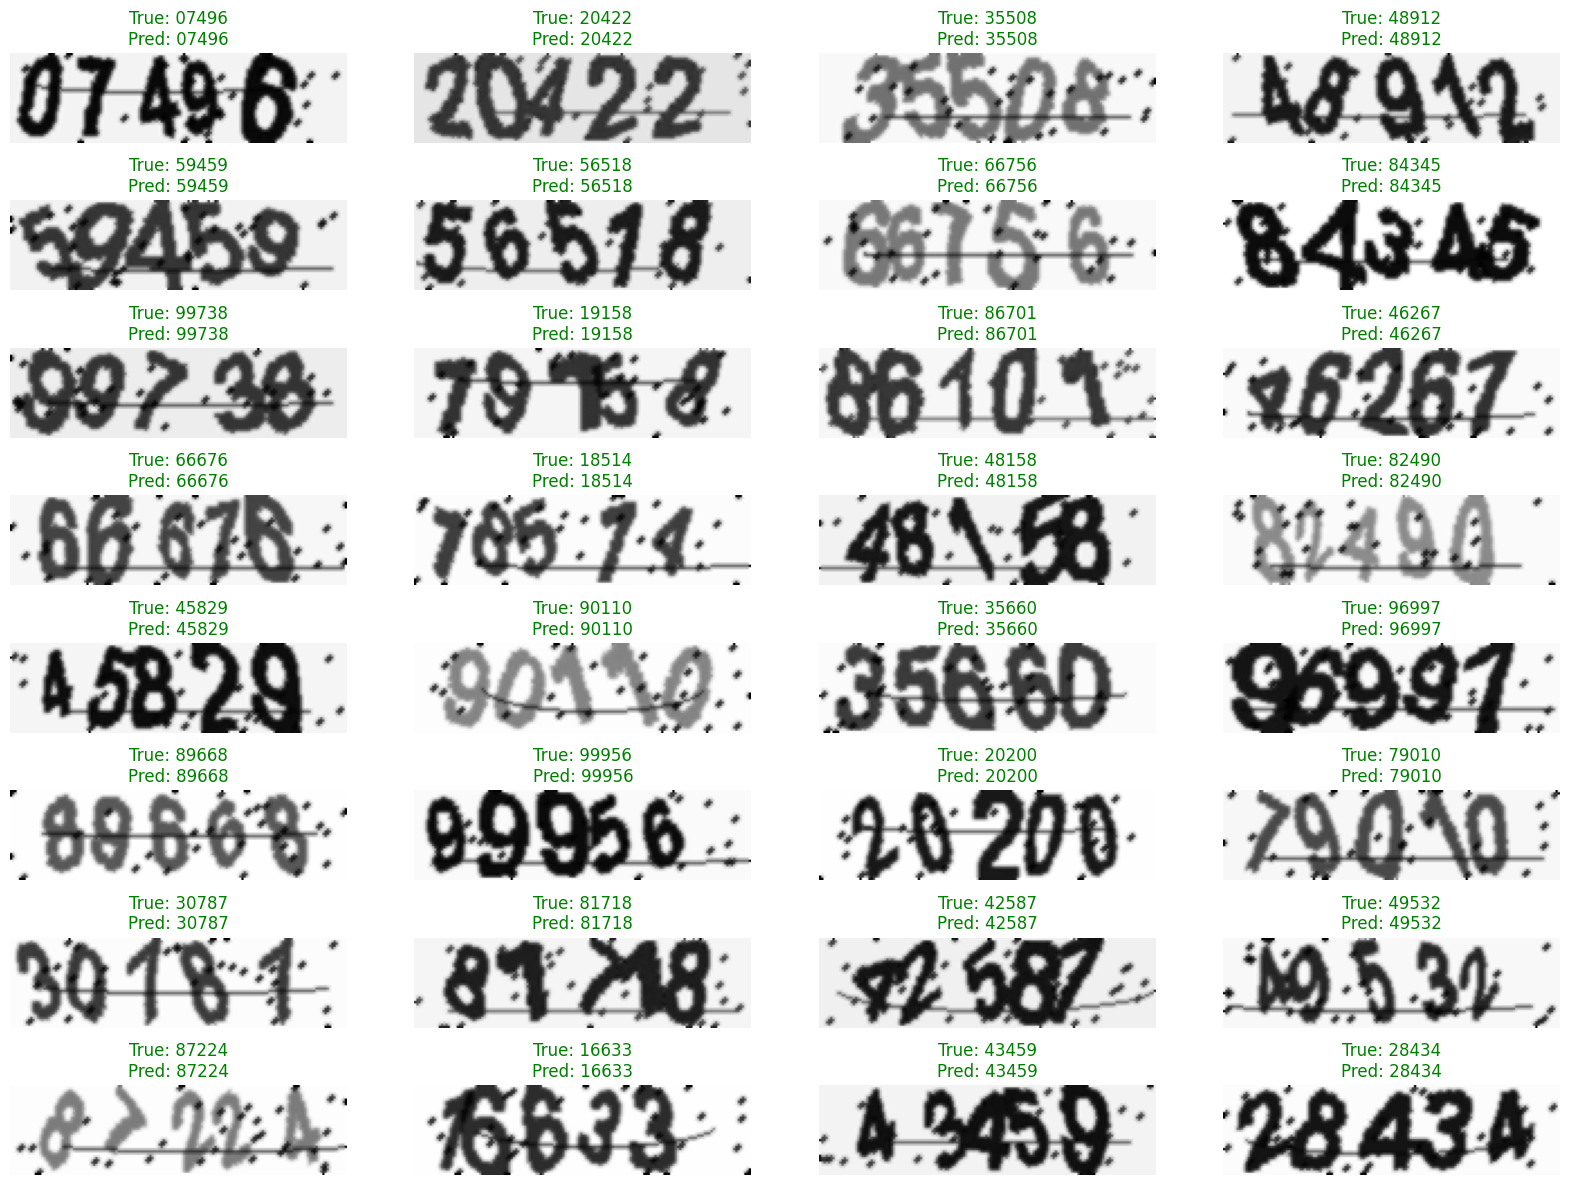

In [25]:
_, ax = plt.subplots(8, 4, figsize=(20, 15))
for batch in valid_dataset.take(1):
    images = batch[0]
    labels = batch[1]

    preds = model_2.predict(images)

    for i in range(8):
        for j in range(4):
            index = i*4+j
            
            img = (images[index]*255).numpy().astype('uint8')

            ori_label = []
            pre_label = []

            for l in labels[index]:
                ori_label.append(np.argmax(l))

            for l in preds[index]:
                pre_label.append(np.argmax(l))

            
            true_label = tf.strings.reduce_join(num_to_char(ori_label)).numpy().decode('utf-8')
            pred_label = tf.strings.reduce_join(num_to_char(pre_label)).numpy().decode('utf-8')

            if true_label == pred_label:
                title_color = 'green'
            else:
                title_color = 'red'
                
            ax[i, j].imshow(img[:, :, 0].T, cmap='gray')
            ax[i, j].set_title('True: '+true_label+'\nPred: '+pred_label, color=title_color)
            ax[i, j].axis('off')
plt.show()

In [26]:
model_2.save('ocr_model.h5')

In [27]:
import pickle

In [28]:
hist_df = pd.DataFrame(history.history)

In [29]:
hist_csv_file = 'ocr_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [30]:
old_hist = pd.read_csv('./ocr_history.csv')

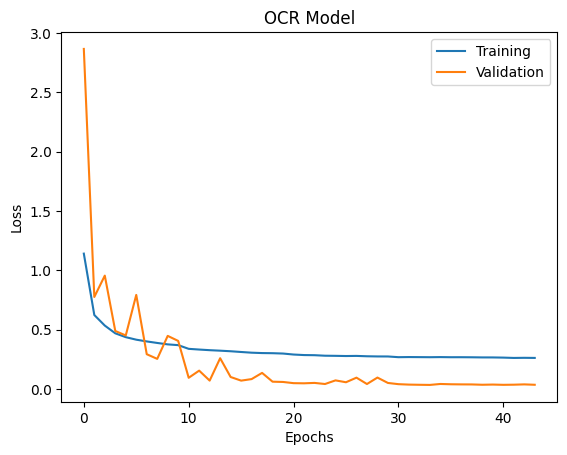

In [31]:
plt.plot(old_hist['loss'])
plt.plot(old_hist['val_loss'])

plt.title('OCR Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

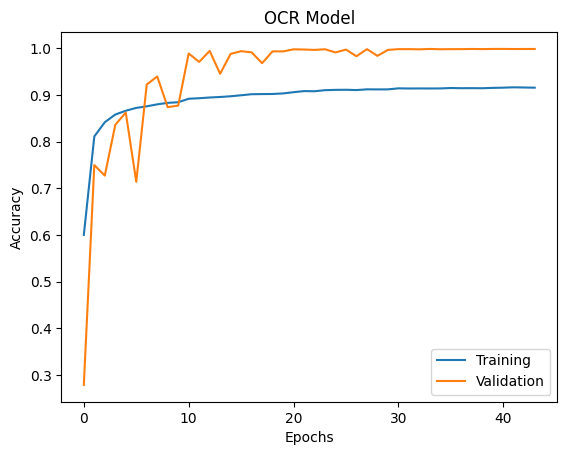

In [32]:
plt.plot(old_hist['acc'])
plt.plot(old_hist['val_acc'])

plt.title('OCR Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()